# Week 4

In [1]:
# =============================
# Standard Libraries
# =============================
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations
from joblib import parallel_backend
from tqdm.auto import tqdm
import kagglehub
from IPython.display import display
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import logging
logging.getLogger("optuna").setLevel(logging.WARNING)
import json
import re


# =============================
# Data Science Libraries
# =============================
import numpy as np
import pandas as pd
import optuna
import scipy.stats as stats
from scipy import sparse
from scipy.stats import loguniform, randint, uniform
from scipy.special import expit, logit


# =============================
# Visualization
# =============================
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import seaborn as sns

# =============================
# Scikit-learn
# =============================
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold,
    ParameterGrid,
)
import sklearn.model_selection._search as sk_search
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeClassifier, LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import sklearn.model_selection._validation as sk_validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.exceptions import NotFittedError
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc


# =============================
# Global
# =============================
random_state = 42
N_ROWS = 5_000_000  # sample size for all datasets
pd.set_option("display.float_format", lambda x: f"{x:.6f}")

# =============================
# Utils
# =============================
def dollar_format(x, pos=None):
    return f"${x:,.0f}"

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

def try_read_csv(folder, fname, **kwargs):
    fp = os.path.join(folder, fname)
    return pd.read_csv(fp, **kwargs) if os.path.exists(fp) else None

def list_csvs(folder):
    return [f for f in os.listdir(folder) if f.lower().endswith(".csv")]

def simple_random_sample(steam, n_rows=None, frac=None, random_state=42):
    if steam is None:
        raise ValueError("steam is None")
    n = len(steam)
    if (n_rows is None) == (frac is None):
        raise ValueError("pass exactly one of n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        k = int(np.floor(frac * n))
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        k = min(int(n_rows), n)
    if k >= n:
        return steam.copy()
    t0 = time.perf_counter()
    rng = np.random.default_rng(random_state)
    idx = rng.choice(n, size=k, replace=False)
    out = steam.iloc[idx].copy()
    t1 = time.perf_counter()
    print({"rows": n, "picked": int(len(out)), "frac": float(len(out) / n), "elapsed_sec": round(t1 - t0, 3)})
    return out

def stratified_sample(steam, y, n_rows=None, frac=None, random_state=42):
    if steam is None:
        raise ValueError("steam is None")
    y_arr = steam[y].to_numpy() if isinstance(y, str) else np.asarray(y)
    n = len(steam)
    if len(y_arr) != n:
        raise ValueError("X and y length mismatch")
    if n_rows is not None and frac is not None:
        frac = None
    if n_rows is None and frac is None:
        raise ValueError("provide n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        test_size = float(frac)
        use_frac, use_n = frac, None
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        test_size = min(float(n_rows) / n, 1.0)
        use_frac, use_n = None, int(n_rows)
    if test_size >= 1.0:
        return steam.copy()
    _, counts = np.unique(y_arr, return_counts=True)
    if np.any(counts < 2):
        print("Warning: some classes <2 samples; using simple sampling.")
        return simple_random_sample(steam, n_rows=use_n, frac=use_frac, random_state=random_state)
    t0 = time.perf_counter()
    idx = np.arange(n)
    _, test_idx, _, _ = train_test_split(
        idx, y_arr, test_size=test_size, stratify=y_arr, random_state=random_state
    )
    out = steam.iloc[test_idx].copy()
    t1 = time.perf_counter()
    print(
        {
            "rows": n,
            "picked": int(len(out)),
            "frac": float(len(out) / n),
            "elapsed_sec": round(t1 - t0, 3),
            "mode": "stratified",
        }
    )
    return out

# =============================
# Load Steam (sample first)
# =============================
steam_path = kagglehub.dataset_download("antonkozyriev/game-recommendations-on-steam")
print("Steam path:", steam_path, "\n", os.listdir(steam_path))

games = try_read_csv(steam_path, "games.csv", low_memory=False)
users = try_read_csv(steam_path, "users.csv", low_memory=False)
recommendations = try_read_csv(steam_path, "recommendations.csv", low_memory=False)

metadata = None
meta_fp = os.path.join(steam_path, "games_metadata.json")
if os.path.exists(meta_fp):
    metadata = pd.read_json(meta_fp, lines=True)

print(
    "Steam shapes:",
    {
        "games": None if games is None else games.shape,
        "users": None if users is None else users.shape,
        "recommendations": None if recommendations is None else recommendations.shape,
        "metadata": None if metadata is None else metadata.shape,
    },
)

steam = None
if recommendations is not None:
    # sample recommendations
    if "is_recommended" in recommendations.columns:
        recs_sample = stratified_sample(recommendations, y="is_recommended", n_rows=N_ROWS, random_state=random_state)
    else:
        recs_sample = simple_random_sample(recommendations, n_rows=N_ROWS, random_state=random_state)

    gm = games
    if metadata is not None and "app_id" in metadata.columns and games is not None and "app_id" in games.columns:
        gm = games.merge(metadata, on="app_id", how="left")

    steam = recs_sample
    if gm is not None and "app_id" in recs_sample.columns and "app_id" in gm.columns:
        steam = steam.merge(gm, on="app_id", how="left")
    if users is not None and "user_id" in steam.columns and "user_id" in users.columns:
        steam = steam.merge(users, on="user_id", how="left")

    print("steam:", steam.shape)

# =============================
# Load Olist
# =============================
olist_path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print("\nOlist path:", olist_path, "\n", os.listdir(olist_path))

olist_customers = try_read_csv(olist_path, "olist_customers_dataset.csv")
olist_geolocation = try_read_csv(olist_path, "olist_geolocation_dataset.csv")
olist_items = try_read_csv(olist_path, "olist_order_items_dataset.csv")
olist_payments = try_read_csv(olist_path, "olist_order_payments_dataset.csv")
olist_reviews = try_read_csv(olist_path, "olist_order_reviews_dataset.csv")
olist_orders = try_read_csv(olist_path, "olist_orders_dataset.csv")
olist_products = try_read_csv(olist_path, "olist_products_dataset.csv")
olist_sellers = try_read_csv(olist_path, "olist_sellers_dataset.csv")
olist_cat_trans = try_read_csv(olist_path, "product_category_name_translation.csv")

print(
    "Olist shapes:",
    {
        "customers": None if olist_customers is None else olist_customers.shape,
        "geolocation": None if olist_geolocation is None else olist_geolocation.shape,
        "items": None if olist_items is None else olist_items.shape,
        "payments": None if olist_payments is None else olist_payments.shape,
        "reviews": None if olist_reviews is None else olist_reviews.shape,
        "orders": None if olist_orders is None else olist_orders.shape,
        "products": None if olist_products is None else olist_products.shape,
        "sellers": None if olist_sellers is None else olist_sellers.shape,
        "category_translation": None if olist_cat_trans is None else olist_cat_trans.shape,
    },
)

olist = None
if all(x is not None for x in [olist_orders, olist_customers, olist_items, olist_products, olist_sellers]):
    # translated category names
    if olist_cat_trans is not None and "product_category_name" in olist_products.columns:
        products_en = olist_products.merge(olist_cat_trans, on="product_category_name", how="left")
    else:
        products_en = olist_products

    # enrich items with product and seller info
    items_ext = (
        olist_items.merge(products_en, on="product_id", how="left")
        .merge(olist_sellers, on="seller_id", how="left", suffixes=("", "_seller"))
    )

    # average lat,lng per ZIP prefix
    if olist_geolocation is not None:
        geo_zip = (
            olist_geolocation.groupby("geolocation_zip_code_prefix", as_index=False).agg(
                geolocation_lat=("geolocation_lat", "mean"),
                geolocation_lng=("geolocation_lng", "mean"),
                geo_points=("geolocation_city", "count"),
            )
        )
        customers_geo = (
            olist_customers.merge(
                geo_zip,
                left_on="customer_zip_code_prefix",
                right_on="geolocation_zip_code_prefix",
                how="left",
            )
            .drop(columns=["geolocation_zip_code_prefix"])
        )
    else:
        customers_geo = olist_customers

    payments_agg = (
        olist_payments.groupby("order_id", as_index=False).agg(
            payment_value_total=("payment_value", "sum"),
            payment_installments_max=("payment_installments", "max"),
            payment_count=("payment_type", "count"),
        )
        if olist_payments is not None
        else None
    )

    reviews_agg = (
        olist_reviews.groupby("order_id", as_index=False).agg(
            review_score_mean=("review_score", "mean"),
            review_count=("review_id", "count"),
        )
        if olist_reviews is not None
        else None
    )

    olist = (
        olist_orders.merge(customers_geo, on="customer_id", how="left")
        .merge(items_ext, on="order_id", how="left")
    )
    if payments_agg is not None:
        olist = olist.merge(payments_agg, on="order_id", how="left")
    if reviews_agg is not None:
        olist = olist.merge(reviews_agg, on="order_id", how="left")

    print("olist:", olist.shape)

    # sample Olist
    olist = simple_random_sample(olist, n_rows=N_ROWS, random_state=random_state)
    print("olist sample:", olist.shape)

# Run immediately after loading/creating `olist`
base_cols = [
    "order_id","customer_id","order_status","order_purchase_timestamp",
    "order_approved_at","order_delivered_carrier_date",
    "order_delivered_customer_date","order_estimated_delivery_date",
    "customer_unique_id","customer_zip_code_prefix","customer_city",
    "customer_state","geolocation_lat","geolocation_lng","geo_points",
    "order_item_id","product_id","seller_id","shipping_limit_date","price",
    "freight_value","product_category_name","product_name_lenght",
    "product_description_lenght","product_photos_qty","product_weight_g",
    "product_length_cm","product_height_cm","product_width_cm",
    "product_category_name_english","seller_zip_code_prefix","seller_city",
    "seller_state","payment_value_total","payment_installments_max",
    "payment_count","review_score_mean","review_count"
]

idx_map = {}
cols_set = set(olist.columns)
for i, name in enumerate(base_cols):
    if i in cols_set:
        idx_map[i] = name
    if str(i) in cols_set:
        idx_map[str(i)] = name

olist = olist.rename(columns=idx_map)


# =============================
# Load Video Games Sales 2019
# =============================
vg2019_path = kagglehub.dataset_download("ashaheedq/video-games-sales-2019")
print("\nVG2019 path:", vg2019_path, "\n", os.listdir(vg2019_path))

sales = None
csvs = list_csvs(vg2019_path)
target_csv = "vgsales-12-4-2019.csv" if "vgsales-12-4-2019.csv" in csvs else (csvs[0] if csvs else None)
if target_csv is not None:
    sales = pd.read_csv(os.path.join(vg2019_path, target_csv), low_memory=False)
    print("sales:", sales.shape, "| file:", target_csv)

    # sample VG2019
    if "Genre" in sales.columns:
        sales = stratified_sample(sales, y="Genre", n_rows=N_ROWS, random_state=random_state)
    else:
        sales = simple_random_sample(sales, n_rows=N_ROWS, random_state=random_state)
    print("sales sample:", sales.shape)
else:
    print("No CSV found in the video-games-sales-2019 dataset.")

# Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos=None):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

pd.set_option("display.float_format", lambda x: f"{x:.6f}")


# =============================
# Final summaries
# =============================
print("\nsteam sample:", None if steam is None else steam.shape)
print("olist sample:", None if olist is None else olist.shape)
print("sales sample:", None if sales is None else sales.shape)

Steam path: /Users/chandlercampbell/.cache/kagglehub/datasets/antonkozyriev/game-recommendations-on-steam/versions/28 
 ['recommendations.csv', 'users.csv', 'games.csv', 'games_metadata.json']
Steam shapes: {'games': (50872, 13), 'users': (14306064, 3), 'recommendations': (41154794, 8), 'metadata': (50872, 3)}
{'rows': 41154794, 'picked': 5000000, 'frac': 0.12149252891412844, 'elapsed_sec': 6.194, 'mode': 'stratified'}
steam: (5000000, 24)

Olist path: /Users/chandlercampbell/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2 
 ['olist_sellers_dataset.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv']
Olist shapes: {'customers': (99441, 5), 'geolocation': (1000163, 5), 'items': (112650, 7), 'payments': (103886, 5), 'reviews': (99224, 7), 'orders': (99441

In [2]:
def prepare_all(
    steam, olist, sales,
    top_k_tags=50, max_total_features=200,
    test_size=0.2, random_state=42,
    balance_method="auto",        # "auto", "oversample", "undersample", "none"
    min_class_ratio=0.7           # balance if minority/majority < this
):
    # ---------- Steam ----------
    df = steam.copy()
    X = df.copy()

    needed_cols = [
        "date", "date_release", "title", "description", "price_final", "price_original", "tags",
        "win", "mac", "linux", "steam_deck",
        "helpful", "funny", "hours", "user_reviews", "products", "reviews"
    ]
    for c in needed_cols:
        if c not in X.columns:
            X[c] = np.nan

    # Dates
    X["date"] = pd.to_datetime(X["date"], errors="coerce")
    X["date_release"] = pd.to_datetime(X["date_release"], errors="coerce")
    X["days_since_release"] = (X["date"] - X["date_release"]).dt.days.clip(lower=0).fillna(0)
    X["review_year"] = X["date"].dt.year.fillna(0)
    X["review_month"] = X["date"].dt.month.fillna(0)
    X["review_dow"] = X["date"].dt.dayofweek.fillna(0)

    # Text lengths
    X["title_len"] = X["title"].fillna("").astype(str).str.len()
    X["desc_len"] = X["description"].fillna("").astype(str).str.len()

    # Log transforms
    for col in ["helpful", "funny", "hours", "user_reviews", "products", "reviews", "price_final", "price_original"]:
        X[col] = pd.to_numeric(X[col], errors="coerce")
        X[col + "_log1p"] = np.log1p(X[col])

    # Prices
    X["is_free"] = X["price_final"].eq(0).astype("int8")
    with np.errstate(divide="ignore", invalid="ignore"):
        X["discount_ratio"] = np.where(
            X["price_original"] > 0,
            1.0 - (X["price_final"] / X["price_original"]),
            0.0
        )
    X["discount_ratio"] = pd.Series(X["discount_ratio"]).clip(0, 1).fillna(0.0)

    # Platform flags
    for b in ["win", "mac", "linux", "steam_deck"]:
        if b not in X.columns:
            X[b] = 0
        X[b] = (X[b] == True).astype("int8")

    keep_dense = [
        "win", "mac", "linux", "steam_deck",
        "days_since_release", "review_year", "review_month", "review_dow",
        "title_len", "desc_len",
        "helpful_log1p", "funny_log1p", "hours_log1p",
        "user_reviews_log1p", "products_log1p", "reviews_log1p",
        "price_final_log1p", "price_original_log1p",
        "discount_ratio", "is_free"
    ]
    for c in keep_dense:
        if c not in X.columns:
            X[c] = np.nan

    steam_df = X[keep_dense].copy()
    steam_df = steam_df.fillna(steam_df.median(numeric_only=True))

    # Tags
    base_cols = steam_df.shape[1]
    allowed_tag_cols = max(0, min(top_k_tags, max_total_features - base_cols))
    if allowed_tag_cols > 0:
        tags_clean = (
            df["tags"].fillna("").astype(str).str.lower()
            .str.replace(r"[\[\]\"]", "", regex=True)
            .str.replace(";", ",").str.replace("/", ",")
        )
        vec = CountVectorizer(
            tokenizer=lambda s: [t.strip() for t in s.split(",") if t.strip()],
            lowercase=False,
            binary=True,
            max_features=allowed_tag_cols
        )
        tag_sparse = vec.fit_transform(tags_clean.values)
        kept_tag_names = [f"tag_{t}" for t in vec.get_feature_names_out()]
        tag_df = pd.DataFrame(tag_sparse.toarray(), columns=kept_tag_names, index=df.index)
        steam_df = pd.concat([steam_df, tag_df], axis=1)

    # Steam target: is_recommended
    if "is_recommended" in df.columns:
        raw = df["is_recommended"]
        if raw.dtype == bool:
            steam_target = raw.astype("int8")
        else:
            text = raw.astype(str).str.lower().str.strip()
            steam_target = np.where(text.isin(["1", "true", "yes", "y", "recommended"]), 1, 0).astype("int8")
    else:
        steam_target = pd.Series(np.nan, index=df.index)

    steam_df = steam_df.assign(target_steam=steam_target)
    steam_df = steam_df[steam_df["target_steam"].notna()].copy()
    steam_df["target_steam"] = steam_df["target_steam"].astype("int8")

    # ---------- Olist ----------
    o = olist.copy()

    date_cols = [
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
        "shipping_limit_date",
    ]
    for c in date_cols:
        if c in o.columns:
            o[c] = pd.to_datetime(o[c], errors="coerce")
        else:
            o[c] = pd.NaT

    o["purchase_dayofweek"] = o["order_purchase_timestamp"].dt.dayofweek
    o["purchase_month"] = o["order_purchase_timestamp"].dt.month
    o["purchase_hour"] = o["order_purchase_timestamp"].dt.hour

    def to_hours(td):
        return td.dt.total_seconds() / 3600.0

    o["approval_delay_h"] = to_hours(o["order_approved_at"] - o["order_purchase_timestamp"])
    o["to_carrier_h"] = to_hours(o["order_delivered_carrier_date"] - o["order_purchase_timestamp"])
    o["to_customer_h"] = to_hours(o["order_delivered_customer_date"] - o["order_purchase_timestamp"])
    o["est_delivery_h"] = to_hours(o["order_estimated_delivery_date"] - o["order_purchase_timestamp"])
    o["limit_from_purchase_h"] = to_hours(o["shipping_limit_date"] - o["order_purchase_timestamp"])

    o["delivered_late"] = (
        (o["order_delivered_customer_date"] > o["order_estimated_delivery_date"])
    ).astype("Int64")

    # Product geometry and density
    for c in ["product_length_cm", "product_width_cm", "product_height_cm", "product_weight_g"]:
        if c not in o.columns:
            o[c] = np.nan
    o["product_volume_cm3"] = o["product_length_cm"] * o["product_width_cm"] * o["product_height_cm"]
    o["density_g_per_cm3"] = np.where(
        (o["product_volume_cm3"] > 0) & o["product_weight_g"].notna(),
        o["product_weight_g"] / o["product_volume_cm3"],
        np.nan,
    )

    # Payments
    for c in ["payment_installments_max", "payment_value_total", "payment_count"]:
        if c not in o.columns:
            o[c] = np.nan
    o["avg_installment_value"] = np.where(
        o["payment_installments_max"] > 0,
        o["payment_value_total"] / o["payment_installments_max"],
        np.nan,
    )
    o["payment_value_per_payment"] = np.where(
        o["payment_count"] > 0,
        o["payment_value_total"] / o["payment_count"],
        np.nan,
    )

    # Freight
    o["freight_value"] = o.get("freight_value", np.nan)
    o["freight_per_kg"] = np.where(
        o["product_weight_g"] > 0,
        o["freight_value"] / (o["product_weight_g"] / 1000.0),
        np.nan,
    )

    # Multi item
    if "order_item_id" not in o.columns:
        o["order_item_id"] = 1
    o["is_multi_item_order"] = (o["order_item_id"] > 1).astype("Int64")

    # Product category normalization
    if "product_category_name" in o.columns and "product_category_name_english" in o.columns:
        o["product_category"] = o["product_category_name_english"].fillna(o["product_category_name"])
        o = o.drop(columns=["product_category_name", "product_category_name_english"])
    elif "product_category_name_english" in o.columns:
        o["product_category"] = o["product_category_name_english"]
        o = o.drop(columns=["product_category_name_english"])
    elif "product_category_name" in o.columns:
        o["product_category"] = o["product_category_name"]
        o = o.drop(columns=["product_category_name"])
    else:
        o["product_category"] = "Unknown"

    # City frequencies
    for col in ["customer_city", "seller_city"]:
        if col in o.columns:
            s_ = o[col].fillna("Unknown")
            freq = s_.map(s_.value_counts(normalize=True))
            o[col + "_freq"] = freq.astype(float)
            o = o.drop(columns=[col])

    # One-hot some cats
    cat_cols = []
    for c in ["order_status", "customer_state", "seller_state", "product_category"]:
        if c in o.columns:
            cat_cols.append(c)
            o[c] = o[c].fillna("Unknown").astype("string")
    if cat_cols:
        o = pd.get_dummies(o, columns=cat_cols, dtype=np.uint8)

    # Drop ids and date columns
    drop_ids = ["order_id", "customer_id", "customer_unique_id", "product_id", "seller_id"]
    o = o.drop(columns=[c for c in drop_ids if c in o.columns], errors="ignore")
    o = o.drop(columns=[c for c in date_cols if c in o.columns], errors="ignore")

    # Olist target: review_score_mean >= 4.0
    if "review_score_mean" in olist.columns:
        review_mean = pd.to_numeric(olist["review_score_mean"], errors="coerce")
        olist_target = (review_mean >= 4.0).astype("Int64")
        o["target_olist"] = olist_target
        o = o[o["target_olist"].notna()].copy()
        o["target_olist"] = o["target_olist"].astype("int8")
    else:
        o["target_olist"] = pd.Series(np.nan, index=o.index)
        o = o[o["target_olist"].notna()].copy()

    # Remove any leftover price column
    if "price" in o.columns:
        o = o.drop(columns=["price"])

    # Remove any leftover review_score_mean column
    if "review_score_mean" in o.columns:
        o = o.drop(columns=["review_score_mean"])

    # Fill missing values
    num_cols = o.select_dtypes(include=[np.number]).columns.tolist()
    num_cols_no_target = [c for c in num_cols if c != "target_olist"]
    for c in num_cols_no_target:
        med = o[c].median()
        o[c] = o[c].fillna(med)

    obj_cols = o.select_dtypes(include=["object"]).columns.tolist()
    for c in obj_cols:
        o[c] = o[c].fillna("Unknown").astype("string")

    olist_df = o.copy()

    # ---------- Sales ----------
    s = sales.copy()

    # Build Sales target from User_Score >= 8.0
    if "User_Score" in s.columns:
        user_score_num = pd.to_numeric(s["User_Score"], errors="coerce")
        s["target_sales"] = (user_score_num >= 8.0).astype("Int64")
    else:
        s["target_sales"] = pd.Series(np.nan, index=s.index)

    # Keep rows with target present
    s = s[s["target_sales"].notna()].copy()
    s["target_sales"] = s["target_sales"].astype("int8")

    # Drop clear leakage or junk
    leak_cols = ["NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales", "Total_Shipped", "Rank"]
    junk_cols = ["VGChartz_Score", "Vgchartzscore", "url", "img_url", "status", "Last_Update", "basename", "User_Score"]
    drop_now = [c for c in leak_cols + junk_cols if c in s.columns]

    # Name flags
    if "Name" in s.columns:
        terms = ["remaster", "remastered", "hd", "definitive", "collection", "trilogy", "anniversary"]
        s["is_remaster"] = s["Name"].astype("string").str.lower().str.contains("|".join(terms), na=False).astype("Int64")
        s = s.drop(columns=["Name"])
    else:
        s["is_remaster"] = pd.Series(0, index=s.index, dtype="Int64")

    # Platform family
    def platform_family(p):
        p = "" if pd.isna(p) else str(p).upper()
        if p.startswith("PS") or p in {"PSP", "PSV"}:
            return "PlayStation"
        if p.startswith("X") or p in {"XB", "XBLA"}:
            return "Xbox"
        if p in {"SWITCH", "WII", "WIIU", "GC", "N64", "SNES", "NES", "DS", "3DS", "GB", "GBC", "GBA"}:
            return "Nintendo"
        if p == "PC":
            return "PC"
        if p in {"DC", "DREAMCAST", "SAT", "GEN", "MD", "MEGADRIVE", "GG"}:
            return "Sega"
        if "ATARI" in p:
            return "Atari"
        return "Other"

    if "Platform" in s.columns:
        s["Platform_Family"] = s["Platform"].apply(platform_family)
        handhelds = {"DS", "3DS", "GB", "GBC", "GBA", "PSP", "PSV"}
        s["is_portable"] = s["Platform"].astype("string").str.upper().isin(handhelds).astype("Int64")
        s = s.drop(columns=["Platform"])
    else:
        s["Platform_Family"] = "Other"
        s["is_portable"] = pd.Series(0, index=s.index, dtype="Int64")

    # Year and decade
    if "Year" in s.columns:
        s["Year"] = pd.to_numeric(s["Year"], errors="coerce")
        s.loc[~s["Year"].between(1970, 2025, inclusive="both"), "Year"] = np.nan
        s["Decade"] = (s["Year"] // 10 * 10).astype("Int64").astype(str)
    else:
        s["Year"] = np.nan
        s["Decade"] = "<NA>"

    s = s.drop(columns=drop_now, errors="ignore")

    # Publisher and Developer frequencies
    for col in ["Publisher", "Developer"]:
        if col in s.columns:
            series = s[col].fillna("Unknown")
            freq = series.map(series.value_counts(normalize=True))
            s[col + "_freq"] = freq.astype(float)
            s = s.drop(columns=[col])

    # One-hot cats
    cat_cols = []
    for c in ["Genre", "ESRB_Rating", "Platform_Family", "Decade"]:
        if c in s.columns:
            cat_cols.append(c)
            s[c] = s[c].fillna("Unknown").astype("string")
    if cat_cols:
        s = pd.get_dummies(s, columns=cat_cols, dtype=np.uint8)

    # Remove Global_Sales if present
    if "Global_Sales" in s.columns:
        s = s.drop(columns=["Global_Sales"])

    # Fill missing values
    num_cols = s.select_dtypes(include=[np.number]).columns.tolist()
    num_cols_no_target = [c for c in num_cols if c != "target_sales"]
    for c in num_cols_no_target:
        med = s[c].median()
        s[c] = s[c].fillna(med)

    obj_cols = s.select_dtypes(include=["object"]).columns.tolist()
    for c in obj_cols:
        s[c] = s[c].fillna("Unknown").astype("string")

    sales_df = s.copy()

    # Shapes before split
    print("\nsteam features shape:", steam_df.drop(columns=["target_steam"]).shape)
    print("olist features shape:", olist_df.drop(columns=["target_olist"]).shape)
    print("sales features shape:", sales_df.drop(columns=["target_sales"]).shape)

    # ---------- Helpers: balancing ----------
    def resample_binary(Xb, yb, method="oversample", random_state=42):
        counts = yb.value_counts(dropna=False)
        if counts.shape[0] != 2:
            return Xb, yb

        majority_class = counts.idxmax()
        minority_class = counts.idxmin()
        majority_idx = yb[yb == majority_class].index.values
        minority_idx = yb[yb == minority_class].index.values

        rng = np.random.RandomState(random_state)

        if method == "undersample":
            keep_majority = rng.choice(majority_idx, size=len(minority_idx), replace=False)
            new_index = np.concatenate([minority_idx, keep_majority])
        else:
            need = int(len(majority_idx) - len(minority_idx))
            if need < 0:
                need = 0
            add_minority = rng.choice(minority_idx, size=need, replace=True)
            new_index = np.concatenate([majority_idx, minority_idx, add_minority])

        rng.shuffle(new_index)
        Xb2 = Xb.loc[new_index].reset_index(drop=True)
        yb2 = yb.loc[new_index].reset_index(drop=True)
        return Xb2, yb2

    def split_and_balance(df_in, target_col, balance_method, min_class_ratio, random_state):
        X_in = df_in.drop(columns=[target_col])
        y_in = df_in[target_col].astype(int)

        if y_in.nunique() == 2:
            X_tr, X_te, y_tr, y_te = train_test_split(
                X_in, y_in, test_size=test_size, random_state=random_state, stratify=y_in
            )
        else:
            X_tr, X_te, y_tr, y_te = train_test_split(
                X_in, y_in, test_size=test_size, random_state=random_state
            )

        vc = y_tr.value_counts()
        if vc.shape[0] == 2:
            minority = vc.min()
            majority = vc.max()
            ratio = float(minority) / float(majority) if majority > 0 else 1.0
            do_balance = balance_method != "none" and ratio < min_class_ratio

            if do_balance:
                if balance_method == "auto":
                    method = "oversample" if len(X_tr) <= 200000 else "undersample"
                else:
                    method = balance_method
                X_tr, y_tr = resample_binary(X_tr, y_tr, method=method, random_state=random_state)

        print(f"{target_col} train class counts:", y_tr.value_counts().to_dict())
        print(f"{target_col} test class counts:", y_te.value_counts().to_dict())
        return X_tr, X_te, y_tr, y_te

    # Splits with balancing
    steam_split = split_and_balance(steam_df, "target_steam",
                                    balance_method, min_class_ratio, random_state)

    olist_split = split_and_balance(olist_df, "target_olist",
                                    balance_method, min_class_ratio, random_state)

    sales_split = split_and_balance(sales_df, "target_sales",
                                    balance_method, min_class_ratio, random_state)

    return {"steam": steam_split, "olist": olist_split, "sales": sales_split}


# Example usage (assumes you already have steam, olist, sales DataFrames)
splits = prepare_all(
    steam, olist, sales,
    balance_method="auto",
    min_class_ratio=0.7
)

# Steam
(X_train_steam, X_test_steam, y_train_steam, y_test_steam) = splits["steam"]
# Olist
(X_train_olist, X_test_olist, y_train_olist, y_test_olist) = splits["olist"]
# Sales
(X_train_sales, X_test_sales, y_train_sales, y_test_sales) = splits["sales"]

print("\nsteam train:", X_train_steam.shape, y_train_steam.shape, "| test:", X_test_steam.shape, y_test_steam.shape)
print("olist train:", X_train_olist.shape, y_train_olist.shape, "| test:", X_test_olist.shape, y_test_olist.shape)
print("sales train:", X_train_sales.shape, y_train_sales.shape, "| test:", X_test_sales.shape, y_test_sales.shape)



steam features shape: (5000000, 70)
olist features shape: (113425, 168)
sales features shape: (55792, 48)
target_steam train class counts: {1: 568623, 0: 568623}
target_steam test class counts: {1: 857844, 0: 142156}
target_olist train class counts: {1: 67535, 0: 67535}
target_olist test class counts: {1: 16884, 0: 5801}
target_sales train class counts: {1: 44438, 0: 44438}
target_sales test class counts: {0: 11110, 1: 49}

steam train: (1137246, 70) (1137246,) | test: (1000000, 70) (1000000,)
olist train: (135070, 168) (135070,) | test: (22685, 168) (22685,)
sales train: (88876, 48) (88876,) | test: (11159, 48) (11159,)


In [ ]:
def run_logistic_regression_comparison(
    X_train_scaled, X_test_scaled,
    X_train_normalized, X_test_normalized,
    y_train, y_test, feature_names=None,
    random_state=42, cv_folds=3, n_iter=12
):

    # Search spaces keep only compatible solver-penalty pairs.
    param_dist = [
    {
        "solver": ["lbfgs", "newton-cg"],
        "penalty": ["l2", "none"],
        "C": loguniform(0.001, 1000),
        "max_iter": [2000, 4000],
        "tol": [0.001, 0.0005]
    },
    {
        "solver": ["liblinear"],
        "penalty": ["l1", "l2"],
        "C": loguniform(0.001, 1000),
        "max_iter": [2000, 4000],
        "tol": [0.001]
    },
    {   
        "solver": ["saga"],
        "penalty": ["l1", "l2"],
        "C": loguniform(0.001, 1000),
        "max_iter": [3000, 5000],
        "tol": [0.001]
    },
    {   
        "solver": ["saga"],
        "penalty": ["elasticnet"],
        "l1_ratio": [0.2, 0.5, 0.8],
        "C": loguniform(0.001, 1000),
        "max_iter": [3000, 5000],
        "tol": [0.001]
    }
]


    results = {}
    datasets = {
        "Standard Scaler": (X_train_scaled, X_test_scaled),
        "Normalizer": (X_train_normalized, X_test_normalized)
    }

    for method, (X_train, X_test) in datasets.items():
        print("\n=== " + method + ": randomized search starting ===")
        start_time = time.time()

        search = RandomizedSearchCV(
            LogisticRegression(random_state=random_state),
            param_distributions=param_dist,
            n_iter=n_iter,
            cv=cv_folds,
            scoring={"accuracy": "accuracy", "roc_auc": "roc_auc"},
            refit="roc_auc",
            random_state=random_state,
            n_jobs=-1,
            verbose=1
        )

        search.fit(X_train, y_train)
        mid_time = time.time()
        print(method + ": search done in " + str(round(mid_time - start_time, 2)) + " sec")
        print(method + ": best params = " + str(search.best_params_))
        model = search.best_estimator_

        # Test predictions
        y_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)

        # Get probabilities
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        else:
            scores = model.decision_function(X_test)
            scores = (scores - scores.min()) / (scores.max() - scores.min() + 0.000000001)
            y_prob = scores

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        test_roc_auc = auc(fpr, tpr)

        # Pull CV means for the chosen params from the search
        best_idx = search.best_index_
        cv_acc_mean = float(search.cv_results_["mean_test_accuracy"][best_idx])
        cv_auc_mean = float(search.cv_results_["mean_test_roc_auc"][best_idx])

        results[method] = {
            "model": model,
            "accuracy": test_accuracy,
            "roc_auc": test_roc_auc,
            "cv_acc_mean": cv_acc_mean,
            "cv_auc_mean": cv_auc_mean,
            "fpr": fpr,
            "tpr": tpr,
            "y_pred": y_pred
        }

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues" if method == "Standard Scaler" else "Greens")
        plt.title(method + " Confusion Matrix (Logistic Regression)")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

        # ROC curve
        plt.figure(figsize=(8, 5))
        plt.plot(fpr, tpr, label=method + " ROC (area = " + str(round(test_roc_auc, 3)) + ")")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.title(method + " ROC Curve (Logistic Regression)")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Top coefficients plot
        if feature_names is not None and hasattr(model, "coef_"):
            coefs = pd.Series(model.coef_[0], index=feature_names)
            top_features = coefs.abs().sort_values(ascending=False).head(10).index
            plt.figure(figsize=(8, 5))
            coefs[top_features].sort_values().plot(
                kind="barh",
                color="skyblue" if method == "Standard Scaler" else "lightgreen"
            )
            plt.title("Top 10 Coefficients (" + method + ")")
            plt.xlabel("Coefficient Value")
            plt.ylabel("Feature")
            plt.tight_layout()
            plt.show()

        end_time = time.time()
        print(method + ": evaluation + plots in " + str(round(end_time - mid_time, 2)) + " sec")

    # Comparison bar chart on test set
    methods = list(results.keys())
    test_accuracies = [results[m]["accuracy"] for m in methods]
    test_aucs = [results[m]["roc_auc"] for m in methods]

    x = np.arange(len(methods))
    width = 0.35
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width / 2, test_accuracies, width, label="Accuracy (Test)", color="skyblue")
    ax.bar(x + width / 2, test_aucs, width, label="ROC AUC (Test)", color="lightgreen")
    ax.set_title("Logistic Regression: Test Set Comparison")
    ax.set_xticks(x)
    ax.set_xticklabels(methods)
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    # CV means from the search
    cv_results_df = pd.DataFrame({
        "Method": methods,
        "CV Accuracy Mean": [results[m]["cv_acc_mean"] for m in methods],
        "CV ROC AUC Mean": [results[m]["cv_auc_mean"] for m in methods],
        "Test Accuracy": test_accuracies,
        "Test ROC AUC": test_aucs
    })

    plt.figure(figsize=(8, 5))
    melted = cv_results_df.melt(id_vars="Method",
                                value_vars=["CV Accuracy Mean", "CV ROC AUC Mean"])
    sns.barplot(data=melted, x="Method", y="value", hue="variable")
    plt.title("Cross-Validation Means (from RandomizedSearchCV)")
    plt.ylabel("Score")
    plt.xlabel("")
    plt.tight_layout()
    plt.show()

    summary_df = pd.DataFrame({
        "Method": methods,
        "Test Accuracy": test_accuracies,
        "Test ROC AUC": test_aucs,
        "CV Accuracy Mean": [results[m]["cv_acc_mean"] for m in methods],
        "CV ROC AUC Mean": [results[m]["cv_auc_mean"] for m in methods]
    })

    return summary_df


In [4]:
standard_scaler = StandardScaler()
X_train_steam_scaled = standard_scaler.fit_transform(X_train_steam)
X_test_steam_scaled = standard_scaler.transform(X_test_steam)
X_train_olist_scaled = standard_scaler.fit_transform(X_train_olist)
X_test_olist_scaled = standard_scaler.transform(X_test_olist)
X_train_sales_scaled = standard_scaler.fit_transform(X_train_sales)
X_test_sales_scaled = standard_scaler.transform(X_test_sales)

normal_scaler = Normalizer()
X_train_steam_normalized = normal_scaler.fit_transform(X_train_steam)
X_test_steam_normalized = normal_scaler.transform(X_test_steam)
X_train_olist_normalized = normal_scaler.fit_transform(X_train_olist)
X_test_olist_normalized = normal_scaler.transform(X_test_olist)
X_train_sales_normalized = normal_scaler.fit_transform(X_train_sales)
X_test_sales_normalized = normal_scaler.transform(X_test_sales)

# Steam Reviews


=== Standard Scaler: randomized search starting ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Standard Scaler: search done in 26.74 sec
Standard Scaler: best params = {'C': np.float64(0.012329623163659839), 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}


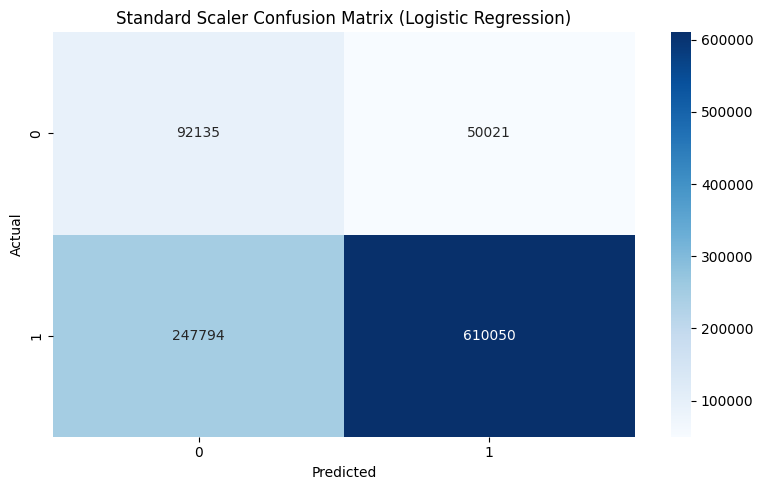

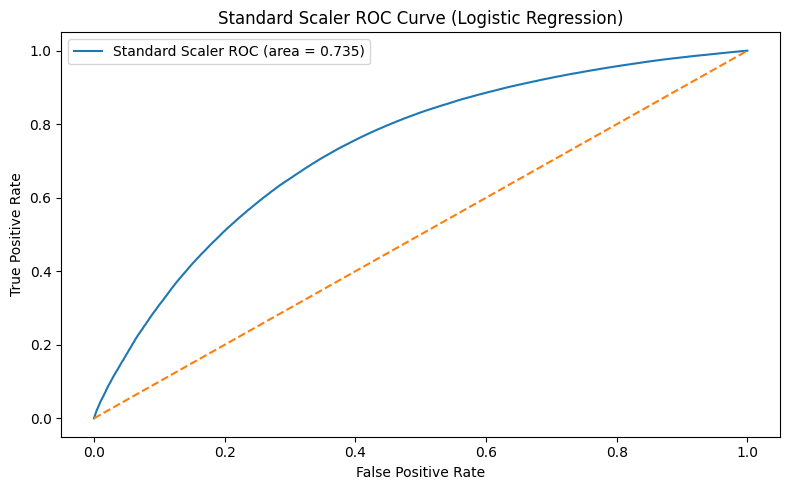

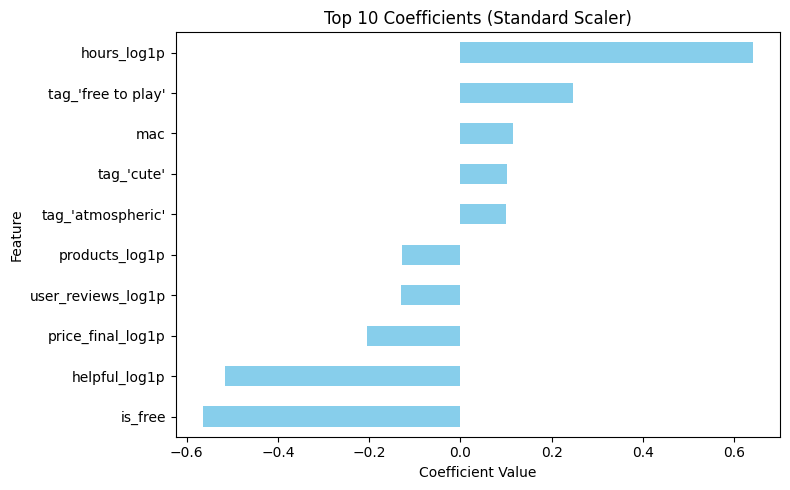

Standard Scaler: evaluation + plots in 0.47 sec

=== Normalizer: randomized search starting ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Normalizer: search done in 852.56 sec
Normalizer: best params = {'C': np.float64(793.2047656808546), 'max_iter': 3000, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.001}


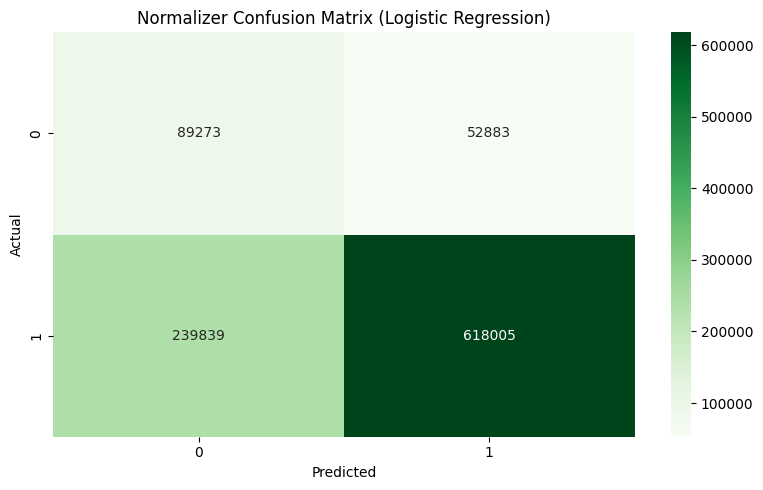

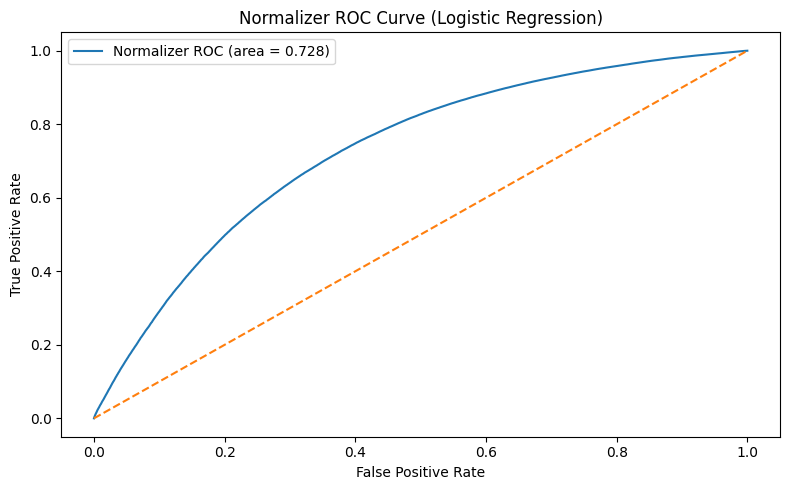

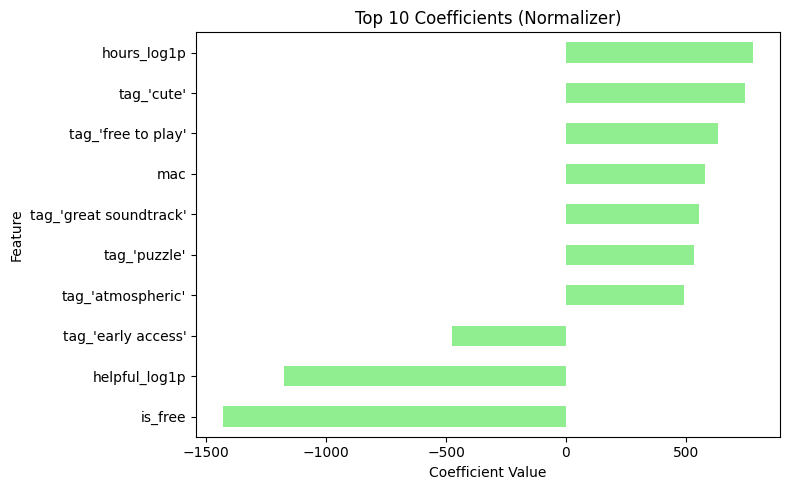

Normalizer: evaluation + plots in 0.67 sec


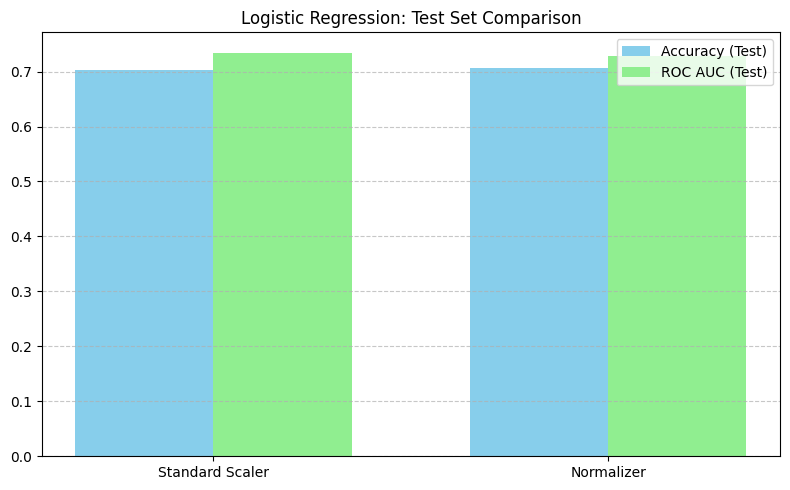

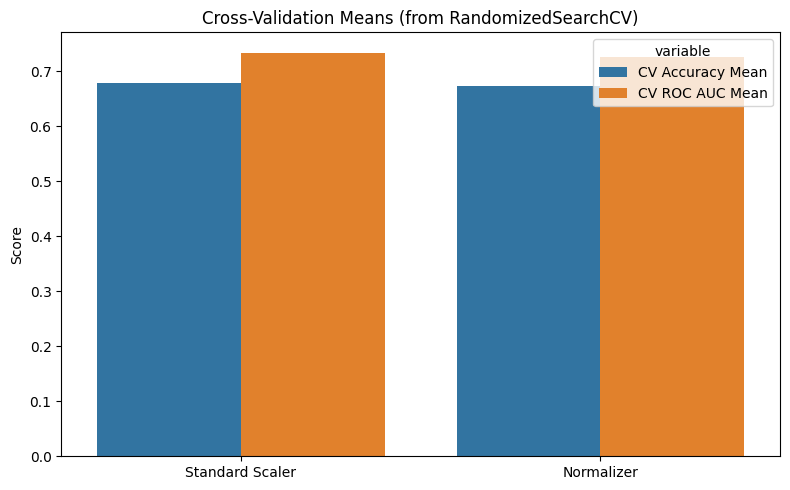

,Method,Test Accuracy,Test ROC AUC,CV Accuracy Mean,CV ROC AUC Mean
0,Standard Scaler,0.702185,0.734600,0.679420,0.734228
1,Normalizer,0.707278,0.728413,0.672817,0.726869


In [7]:
summary_steam = run_logistic_regression_comparison(
    X_train_steam_scaled, X_test_steam_scaled,
    X_train_steam_normalized, X_test_steam_normalized,
    y_train_steam, y_test_steam,
    feature_names=X_train_steam.columns,
    random_state=42
)
summary_steam

# Olist Transactions


=== Standard Scaler: randomized search starting ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Standard Scaler: search done in 62.55 sec
Standard Scaler: best params = {'C': np.float64(0.055895242052179224), 'max_iter': 2000, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.0005}


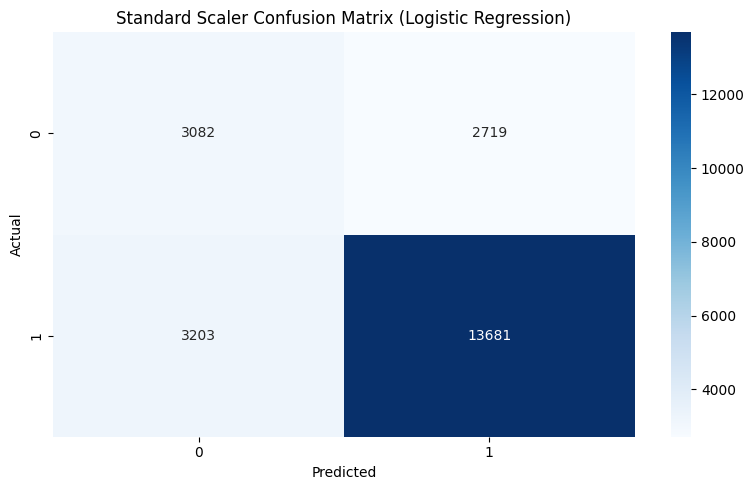

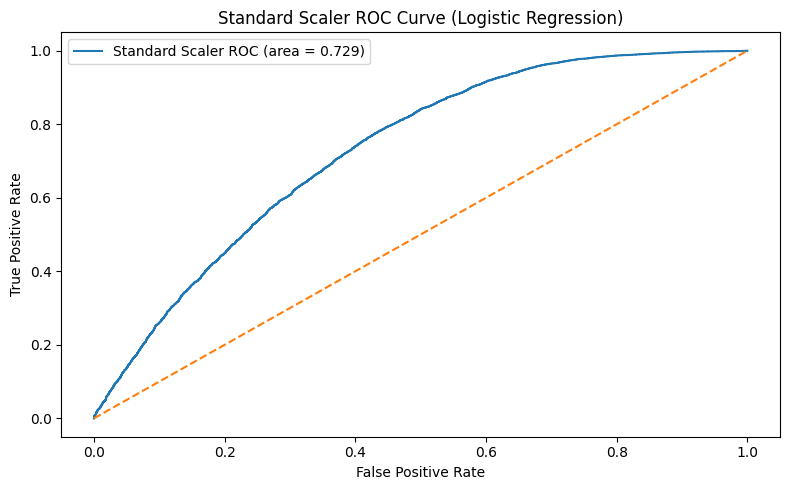

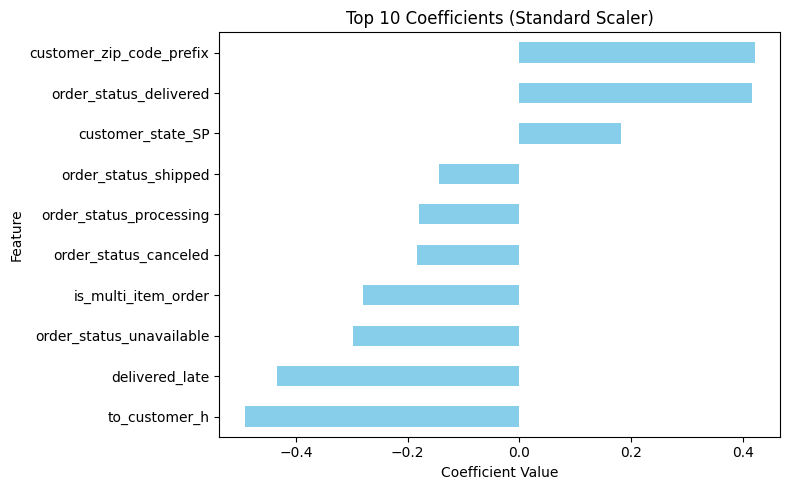

Standard Scaler: evaluation + plots in 0.13 sec

=== Normalizer: randomized search starting ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Normalizer: search done in 115.82 sec
Normalizer: best params = {'C': np.float64(793.2047656808546), 'max_iter': 3000, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.001}


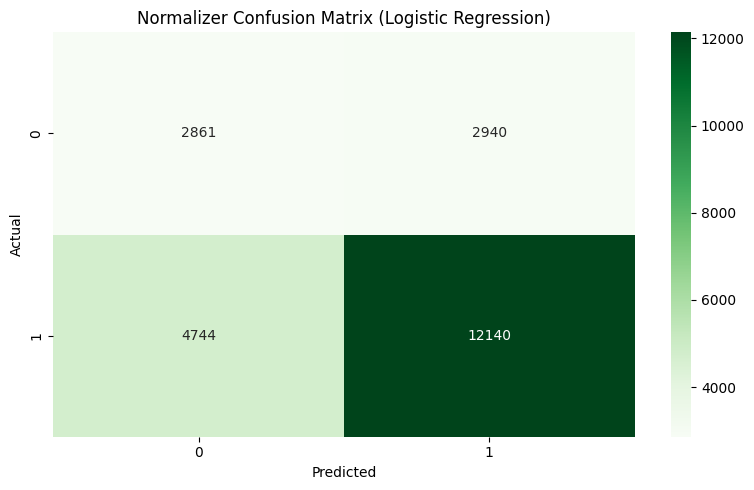

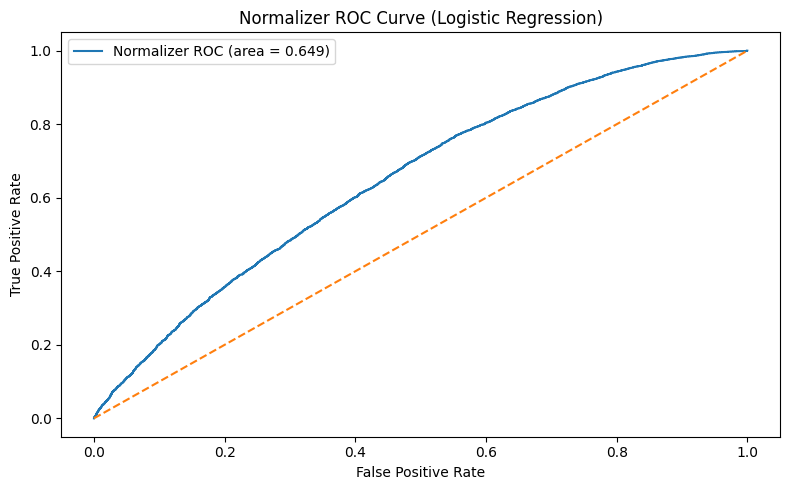

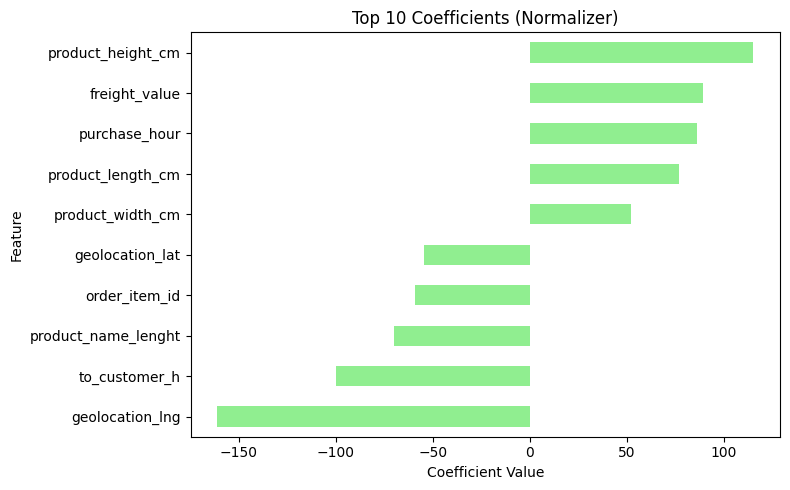

Normalizer: evaluation + plots in 0.12 sec


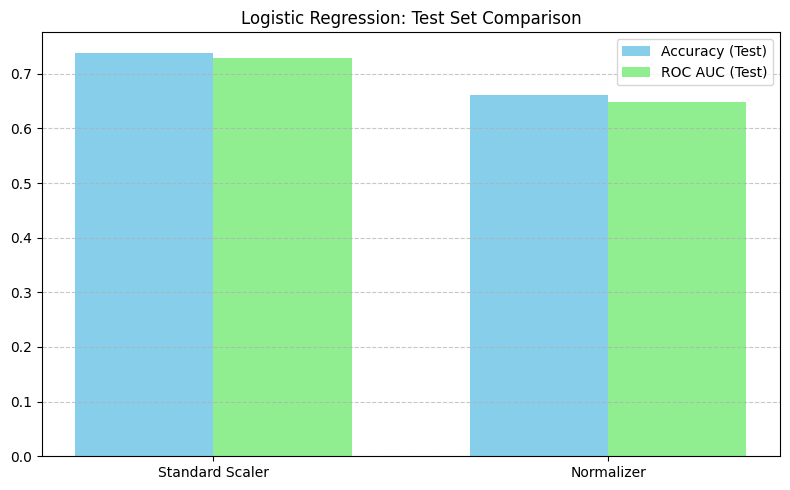

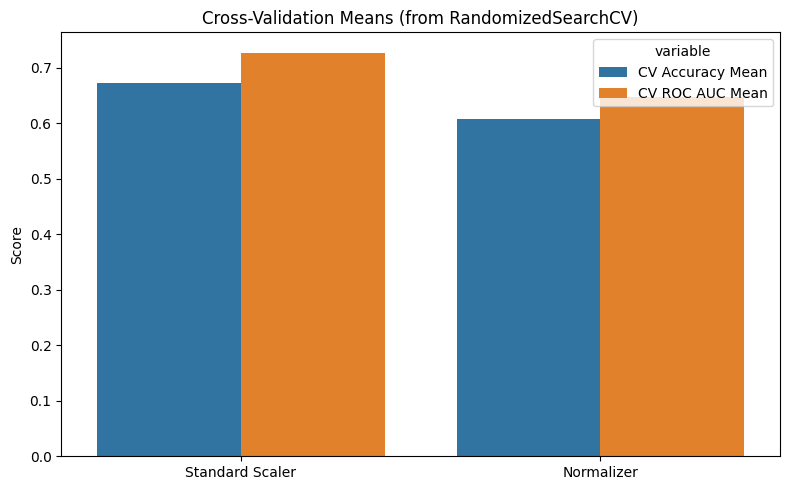

,Method,Test Accuracy,Test ROC AUC,CV Accuracy Mean,CV ROC AUC Mean
0,Standard Scaler,0.738946,0.728530,0.672155,0.727217
1,Normalizer,0.661274,0.648714,0.607330,0.647164


In [8]:
summary_olist = run_logistic_regression_comparison(
    X_train_olist_scaled, X_test_olist_scaled,
    X_train_olist_normalized, X_test_olist_normalized,
    y_train_olist, y_test_olist,
    feature_names=X_train_olist.columns,
    random_state=42
)
summary_olist

# Video Game Sales


=== Standard Scaler: randomized search starting ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Standard Scaler: search done in 4.88 sec
Standard Scaler: best params = {'C': np.float64(4.418441521199722), 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.0005}


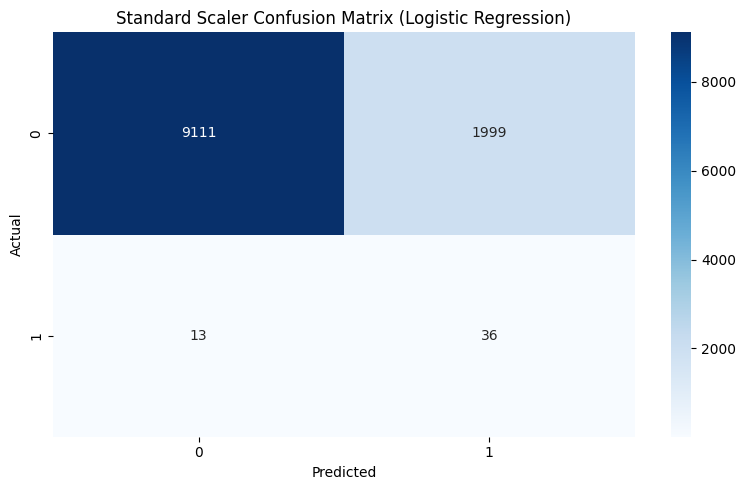

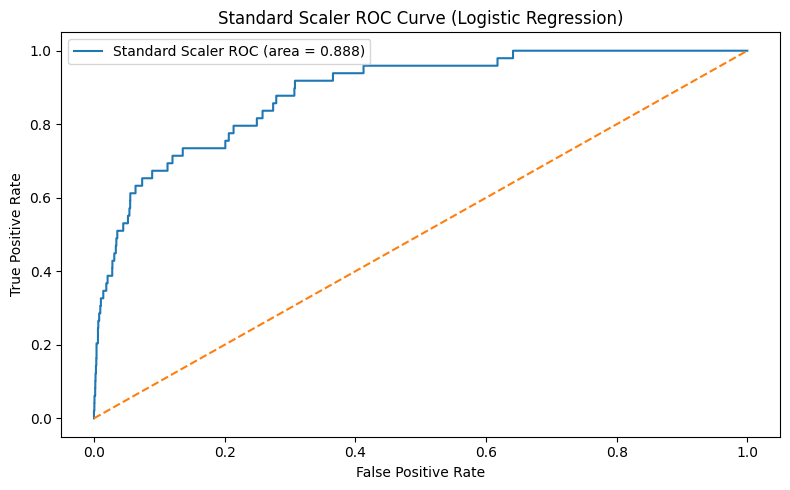

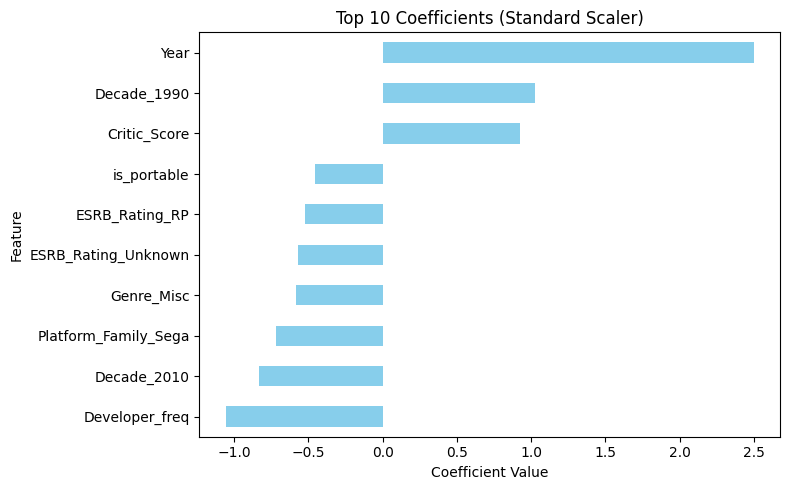

Standard Scaler: evaluation + plots in 0.12 sec

=== Normalizer: randomized search starting ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Normalizer: search done in 28.19 sec
Normalizer: best params = {'C': np.float64(793.2047656808546), 'max_iter': 3000, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.001}


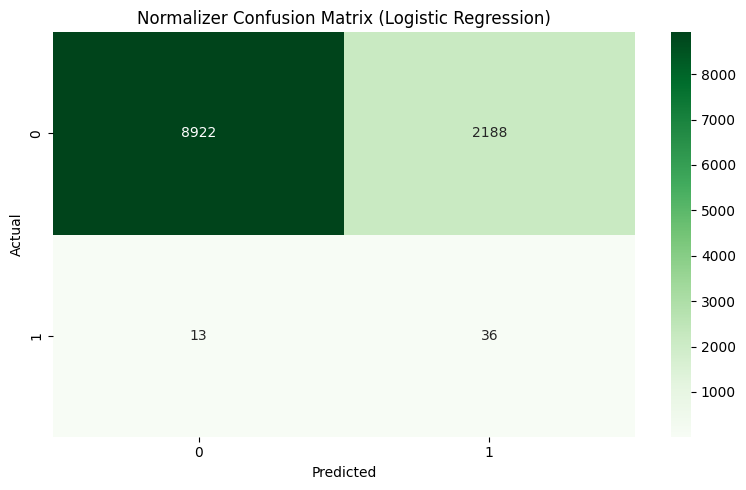

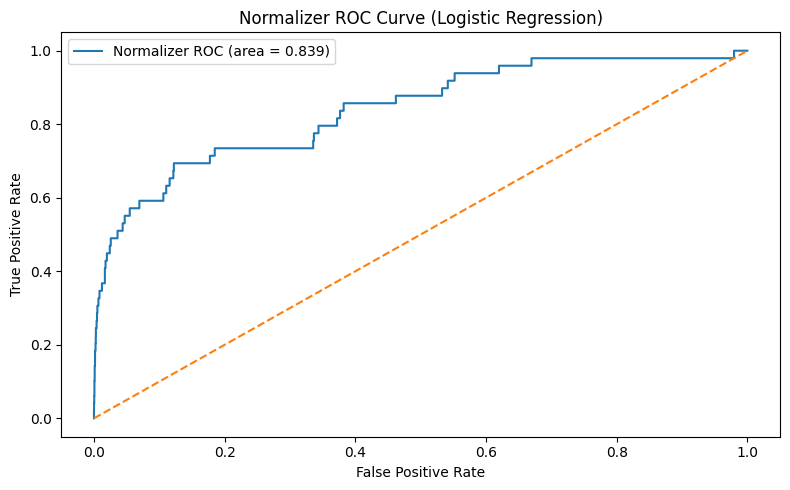

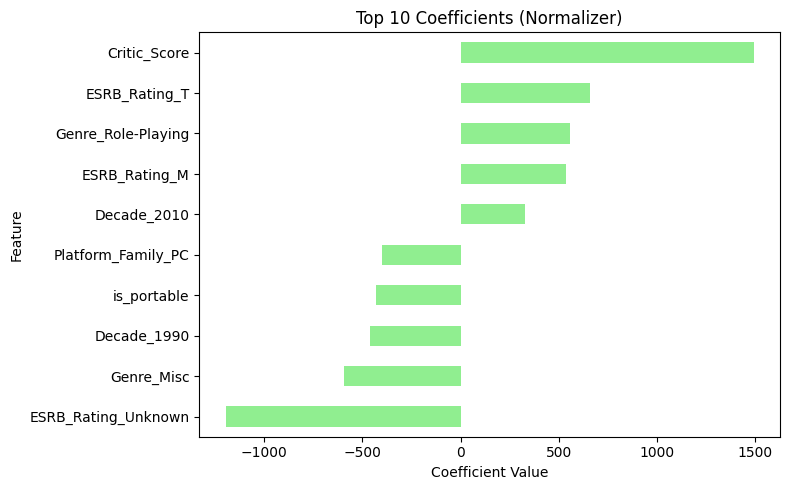

Normalizer: evaluation + plots in 0.12 sec


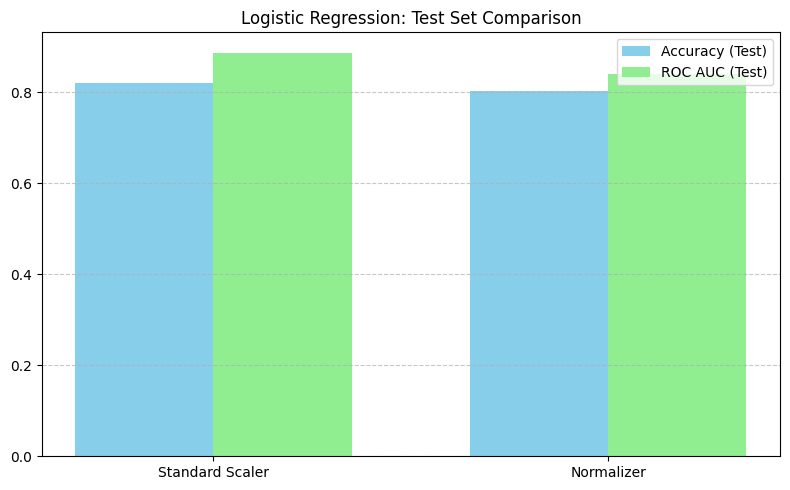

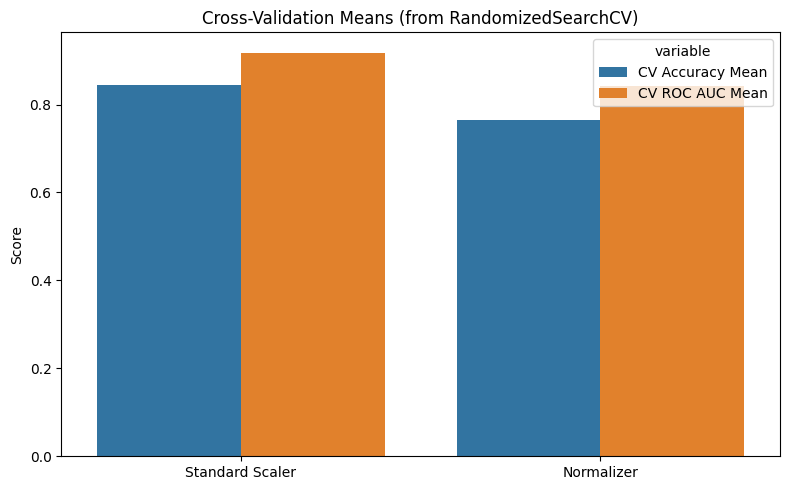

,Method,Test Accuracy,Test ROC AUC,CV Accuracy Mean,CV ROC AUC Mean
0,Standard Scaler,0.819697,0.887637,0.843614,0.918354
1,Normalizer,0.802760,0.839324,0.764245,0.841579


In [9]:
summary_sales = run_logistic_regression_comparison(
    X_train_sales_scaled, X_test_sales_scaled,
    X_train_sales_normalized, X_test_sales_normalized,
    y_train_sales, y_test_sales,
    feature_names=X_train_sales.columns,
    random_state=42
)
summary_sales